In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import  mean_squared_error, r2_score
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf 

In [2]:
index= ["engine", "cycle"]
setting = [f"op_setting_{i}" for i in range(1, 4)]
sensor = [
    "Fan inlet temperature (◦R)",
    "LPC outlet temperature (◦R)",
    "HPC outlet temperature (◦R)",
    "LPT outlet temperature (◦R)",
    "Fan inlet Pressure (psia)",
    "Bypass-duct pressure (psia)",
    "HPC outlet pressure (psia)",
    "Physical fan speed (rpm)",
    "Physical core speed (rpm)",
    "Engine pressure ratio (P50/P2)",
    "HPC outlet Static pressure (psia)",
    "Ratio of fuel flow to Ps30 (pps/psia)",
    "Corrected fan speed (rpm)",
    "Corrected core speed (rpm)",
    "Bypass Ratio",
    "Burner fuel-air ratio",
    "Bleed Enthalpy",
    "Required fan speed",
    "Required fan conversion speed",
    "High-pressure turbines Cool air flow",
    "Low-pressure turbines Cool air flow",
]
col_names = index + setting + sensor 
train = pd.read_csv("../../data/raw/train_FD001.txt",sep="\s+", header=None, names = col_names) #separate by whitespace, the + is for one or more spaces
test  = pd.read_csv("../../data/raw/test_FD001.txt",sep="\s+", header=None, names = col_names)
rul = pd.read_csv("../../data/raw/RUL_FD001.txt", sep="\s+", header=None, names=['RUL'])

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\s'
C:\Users\halah\AppData\Local\Temp\ipykernel_12096\600742346.py:27: SyntaxWarning: invalid escape sequence '\s'
  train = pd.read_csv("../../data/raw/train_FD001.txt",sep="\s+", header=None, names = col_names) #separate by whitespace, the + is for one or more spaces
C:\Users\halah\AppData\Local\Temp\ipykernel_12096\600742346.py:28: SyntaxWarning: invalid escape sequence '\s'
  test  = pd.read_csv("../../data/raw/test_FD001.txt",sep="\s+", header=None, names = col_names)
C:\Users\halah\AppData\Local\Temp\ipykernel_12096\600742346.py:29: SyntaxWarning: invalid escape sequence '\s'
  rul = pd.read_csv("../../data/raw/RUL_FD001.txt", sep="\s+", header=None, names=['RUL'])


In [3]:
train.head()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
test.head()

,engine,cycle,op_setting_1,op_setting_2,op_setting_3,Fan inlet temperature (◦R),LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Fan inlet Pressure (psia),...,Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Burner fuel-air ratio,Bleed Enthalpy,Required fan speed,Required fan conversion speed,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   engine                                 20631 non-null  int64  
 1   cycle                                  20631 non-null  int64  
 2   op_setting_1                           20631 non-null  float64
 3   op_setting_2                           20631 non-null  float64
 4   op_setting_3                           20631 non-null  float64
 5   Fan inlet temperature (◦R)             20631 non-null  float64
 6   LPC outlet temperature (◦R)            20631 non-null  float64
 7   HPC outlet temperature (◦R)            20631 non-null  float64
 8   LPT outlet temperature (◦R)            20631 non-null  float64
 9   Fan inlet Pressure (psia)              20631 non-null  float64
 10  Bypass-duct pressure (psia)            20631 non-null  float64
 11  HP

In [6]:
train.shape

(20631, 26)

In [7]:
test.shape

(13096, 26)

In [8]:
rul.shape

(100, 1)

In [9]:
train.isna().sum()

engine                                   0
cycle                                    0
op_setting_1                             0
op_setting_2                             0
op_setting_3                             0
Fan inlet temperature (◦R)               0
LPC outlet temperature (◦R)              0
HPC outlet temperature (◦R)              0
LPT outlet temperature (◦R)              0
Fan inlet Pressure (psia)                0
Bypass-duct pressure (psia)              0
HPC outlet pressure (psia)               0
Physical fan speed (rpm)                 0
Physical core speed (rpm)                0
Engine pressure ratio (P50/P2)           0
HPC outlet Static pressure (psia)        0
Ratio of fuel flow to Ps30 (pps/psia)    0
Corrected fan speed (rpm)                0
Corrected core speed (rpm)               0
Bypass Ratio                             0
Burner fuel-air ratio                    0
Bleed Enthalpy                           0
Required fan speed                       0
Required fa

In [10]:
test.isna().sum()

engine                                   0
cycle                                    0
op_setting_1                             0
op_setting_2                             0
op_setting_3                             0
Fan inlet temperature (◦R)               0
LPC outlet temperature (◦R)              0
HPC outlet temperature (◦R)              0
LPT outlet temperature (◦R)              0
Fan inlet Pressure (psia)                0
Bypass-duct pressure (psia)              0
HPC outlet pressure (psia)               0
Physical fan speed (rpm)                 0
Physical core speed (rpm)                0
Engine pressure ratio (P50/P2)           0
HPC outlet Static pressure (psia)        0
Ratio of fuel flow to Ps30 (pps/psia)    0
Corrected fan speed (rpm)                0
Corrected core speed (rpm)               0
Bypass Ratio                             0
Burner fuel-air ratio                    0
Bleed Enthalpy                           0
Required fan speed                       0
Required fa

In [11]:
train.duplicated().sum()

np.int64(0)

In [12]:
test.duplicated().sum()

np.int64(0)

In [13]:
print("Number of engines in train dataset:", train['engine'].nunique())

Number of engines in train dataset: 100


In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
Fan inlet temperature (◦R),20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
LPC outlet temperature (◦R),20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
HPC outlet temperature (◦R),20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
LPT outlet temperature (◦R),20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Fan inlet Pressure (psia),20631.0,14.620000,5.329200e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [15]:
#From the description of the dataframe we see some columns who seem to be constant (same min and max values) these wont help us so it is safe to drop them
constant_cols = [col for col in train.columns if train[col].nunique() == 1]

print("Columns with constant values:" , constant_cols)
train.drop(constant_cols, axis=1, inplace=True, errors='ignore')
test.drop(constant_cols, axis=1, inplace=True, errors='ignore')

Columns with constant values: ['op_setting_3', 'Fan inlet temperature (◦R)', 'Fan inlet Pressure (psia)', 'Engine pressure ratio (P50/P2)', 'Burner fuel-air ratio', 'Required fan speed', 'Required fan conversion speed']


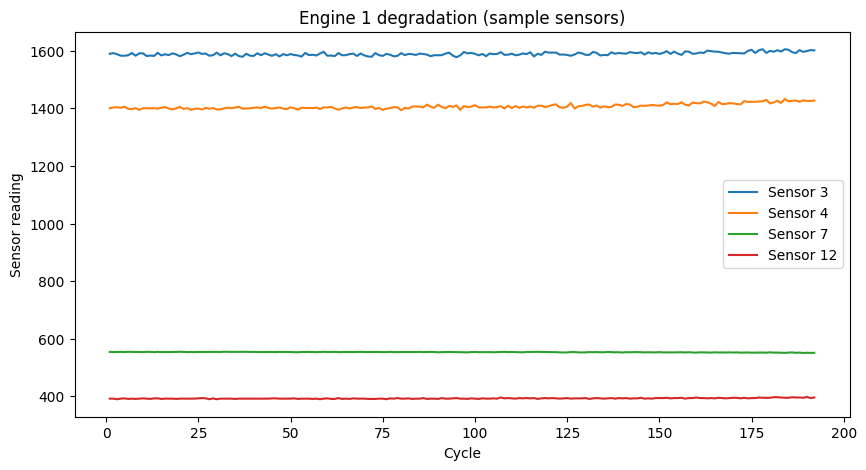

In [16]:
engine1 = train[train['engine']==1]
plt.figure(figsize=(10,5))
plt.plot(engine1['cycle'], engine1['HPC outlet temperature (◦R)'], label='Sensor 3')
plt.plot(engine1['cycle'], engine1['LPT outlet temperature (◦R)'], label='Sensor 4')
plt.plot(engine1['cycle'], engine1['HPC outlet pressure (psia)'], label='Sensor 7')
plt.plot(engine1['cycle'], engine1['Bleed Enthalpy'], label='Sensor 12')
plt.xlabel("Cycle")
plt.ylabel("Sensor reading")
plt.title("Engine 1 degradation (sample sensors)")
plt.legend()
plt.show()

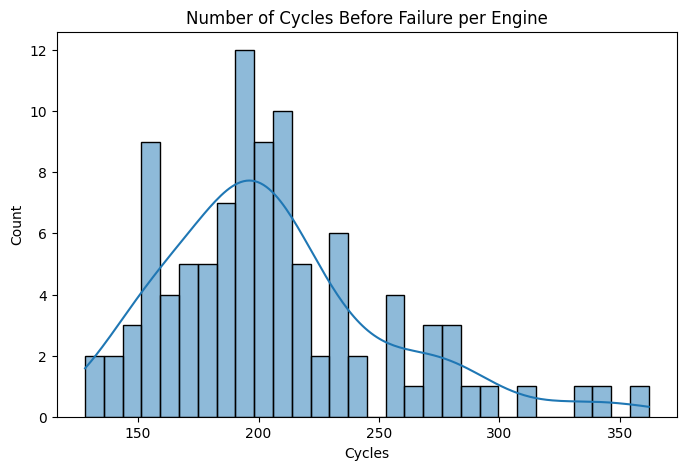

In [17]:
cycles_per_engine = train.groupby('engine')['cycle'].max()
plt.figure(figsize=(8,5))
sns.histplot(cycles_per_engine, bins=30, kde=True)
plt.title("Number of Cycles Before Failure per Engine")
plt.xlabel("Cycles")
plt.ylabel("Count")
plt.show()

In [18]:
#identifies max cycle for each engine
train['max_cycle'] = train.groupby('engine')['cycle'].transform('max')
#calculates RUL to each cycle 
train['RUL'] = train['max_cycle'] - train['cycle']
#remove max_cycle col as it is no longer needed
train = train.drop('max_cycle', axis=1)
train

,engine,cycle,op_setting_1,op_setting_2,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [19]:
#load true RUL values from RUL_FD001.txt
rul_values= rul['RUL'].values

#find the last cycle (max_cycle) for each engine in the test set
test['max_cycle'] = test.groupby('engine')['cycle'].transform('max')

#we create a new dataframe test_rul to facilitate the merge operation
#it contains each engine, its max_cycle and the corresponding true RUL value
test_rul = pd.DataFrame({"engine": test['engine'].unique(), "max_cycle": test.groupby('engine')['cycle'].max().values, "true_RUL": rul_values})

#merge this mapping back to the test set
test= test.merge(test_rul, on=['engine', 'max_cycle'], how='left')
test['RUL'] = test['true_RUL'] + (test['max_cycle'] - test['cycle']) #this computation gives the RUL for each cycle in the test set (decreases linearly)
test= test.drop(columns=['max_cycle', 'true_RUL'])
test

,engine,cycle,op_setting_1,op_setting_2,LPC outlet temperature (◦R),HPC outlet temperature (◦R),LPT outlet temperature (◦R),Bypass-duct pressure (psia),HPC outlet pressure (psia),Physical fan speed (rpm),Physical core speed (rpm),HPC outlet Static pressure (psia),Ratio of fuel flow to Ps30 (pps/psia),Corrected fan speed (rpm),Corrected core speed (rpm),Bypass Ratio,Bleed Enthalpy,High-pressure turbines Cool air flow,Low-pressure turbines Cool air flow,RUL
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,643.24,1599.45,1415.79,21.61,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,643.22,1595.69,1422.05,21.61,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,643.44,1593.15,1406.82,21.61,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,643.26,1594.99,1419.36,21.61,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,21


In [20]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,29.227633,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,68.880990,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0000,0.0003,0.0006
LPC outlet temperature (◦R),20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
HPC outlet temperature (◦R),20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
LPT outlet temperature (◦R),20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Bypass-duct pressure (psia),20631.0,21.609803,0.001389,21.6000,21.6100,21.6100,21.6100,21.6100
HPC outlet pressure (psia),20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
Physical fan speed (rpm),20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600


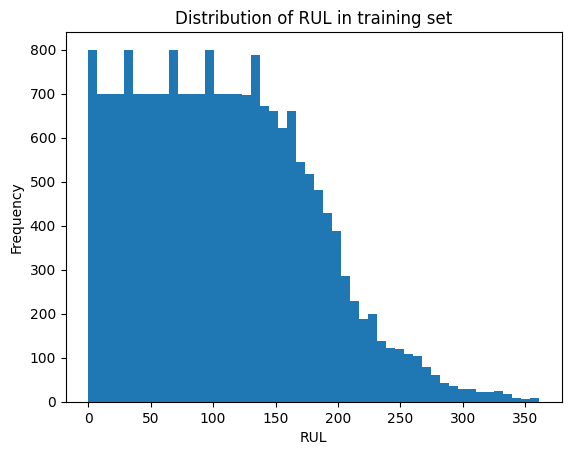

In [21]:
plt.hist(train['RUL'], bins=50)
plt.xlabel("RUL")
plt.ylabel("Frequency")
plt.title("Distribution of RUL in training set")
plt.show()

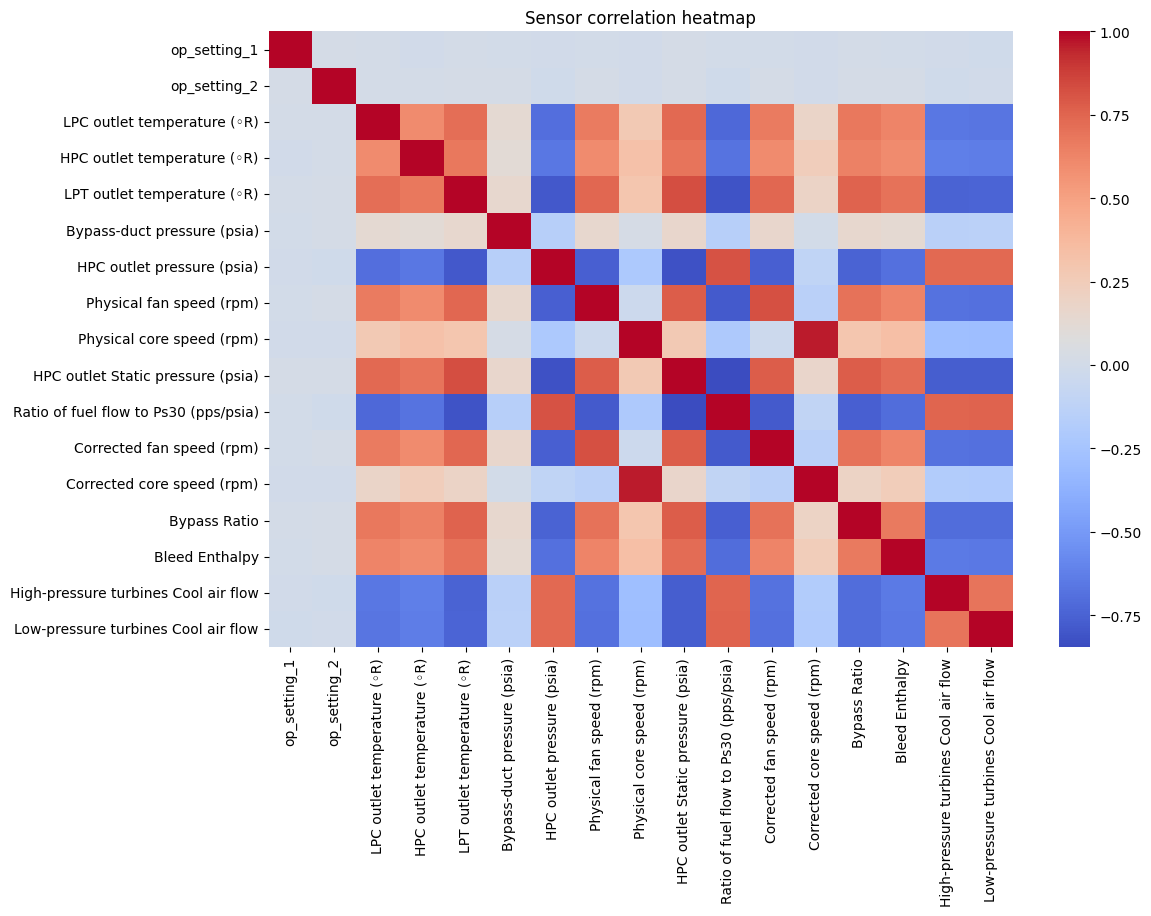

In [22]:
plt.figure(figsize=(12,8))
sns.heatmap(train.drop(columns=['engine','cycle','RUL']).corr(), cmap="coolwarm")
plt.title("Sensor correlation heatmap")
plt.show()

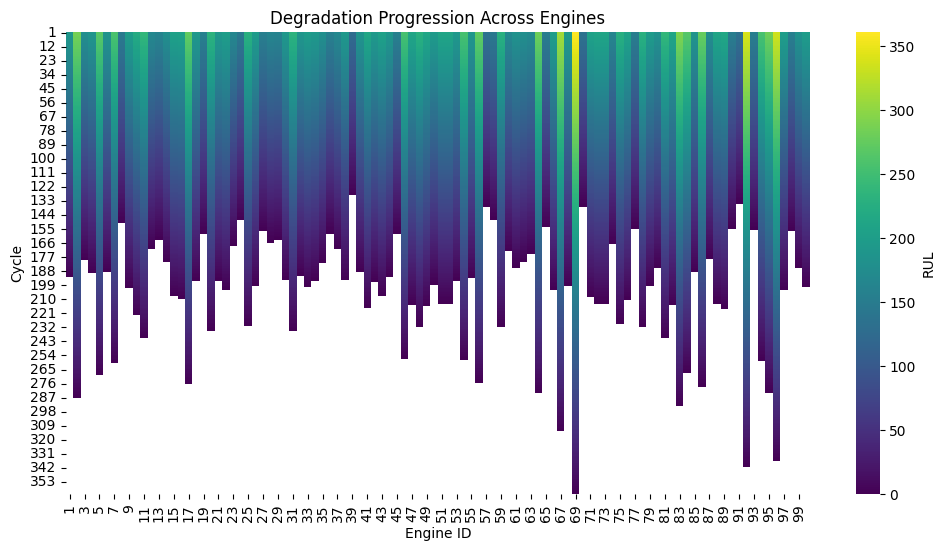

In [23]:
pivot_df = train.pivot_table(index='cycle', columns='engine', values='RUL')
plt.figure(figsize=(12,6))
sns.heatmap(pivot_df, cmap='viridis', cbar_kws={'label': 'RUL'})
plt.title("Degradation Progression Across Engines")
plt.xlabel("Engine ID")
plt.ylabel("Cycle")
plt.show()

In [24]:
sensor_cols = [c for c in train.columns if c not in ['engine','cycle','RUL','op_setting_1','op_setting_2']]
useful_sensors = [col for col in sensor_cols if col not in constant_cols]
print("Useful sensors:", useful_sensors)

Useful sensors: ['LPC outlet temperature (◦R)', 'HPC outlet temperature (◦R)', 'LPT outlet temperature (◦R)', 'Bypass-duct pressure (psia)', 'HPC outlet pressure (psia)', 'Physical fan speed (rpm)', 'Physical core speed (rpm)', 'HPC outlet Static pressure (psia)', 'Ratio of fuel flow to Ps30 (pps/psia)', 'Corrected fan speed (rpm)', 'Corrected core speed (rpm)', 'Bypass Ratio', 'Bleed Enthalpy', 'High-pressure turbines Cool air flow', 'Low-pressure turbines Cool air flow']


In [25]:
train['RUL'] = train['RUL'].clip(upper=125)

In [26]:
scaler = MinMaxScaler()
train[useful_sensors] = scaler.fit_transform(train[useful_sensors])
test[useful_sensors]  = scaler.transform(test[useful_sensors])
##joblib.dump(scaler, 'scaler.pkl')

In [27]:
engine_ids = train['engine'].unique()
n_val = int(len(engine_ids) * 0.2)

train_ids = engine_ids[:-n_val]
val_ids   = engine_ids[-n_val:]

train_data = train[train['engine'].isin(train_ids)]
val_data   = train[train['engine'].isin(val_ids)]

In [28]:
SEQUENCE_LENGTH = 50

def create_sequences(df, seq_len, features):
    """Convert engine run data into overlapping sequences for LSTM."""
    X, y = [], []
    for engine_id in df['engine'].unique():
        engine_df = df[df['engine'] == engine_id]
        vals = engine_df[features].values
        rul_vals = engine_df['RUL'].values

        for i in range(len(vals) - seq_len):
            X.append(vals[i:i + seq_len])
            y.append(rul_vals[i + seq_len])
    return np.array(X), np.array(y)


In [29]:
def create_test_sequences(df, seq_len, features):
    """Create test samples using only the last sequence of each engine."""
    X, ids = [], []
    for engine_id in sorted(df['engine'].unique()):
        engine_df = df[df['engine'] == engine_id]
        if len(engine_df) >= seq_len:
            X.append(engine_df[features].iloc[-seq_len:].values)
            ids.append(engine_id)
    return np.array(X), ids


In [30]:
X_train, y_train = create_sequences(train_data, SEQUENCE_LENGTH, useful_sensors)
X_val, y_val     = create_sequences(val_data, SEQUENCE_LENGTH, useful_sensors)
X_test, test_ids = create_test_sequences(test, SEQUENCE_LENGTH, useful_sensors)

In [31]:
rul_df = rul.reset_index()
rul_df['engine'] = rul_df.index + 1
y_test = rul_df.set_index('engine').loc[test_ids]['RUL'].values

In [32]:
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(SEQUENCE_LENGTH, len(useful_sensors))),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])


c:\Users\halah\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True)
lr_reduce  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_lstm_fd001.keras', monitor='val_loss', save_best_only=True)

In [34]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    shuffle=False,      # critical for time-series
    callbacks=[early_stop, lr_reduce, checkpoint],
    verbose=1
)

Epoch 1/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 3769.1067 - root_mean_squared_error: 61.3931 - val_loss: 2054.2847 - val_root_mean_squared_error: 45.3242 - learning_rate: 0.0010
Epoch 2/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 1708.2543 - root_mean_squared_error: 41.3310 - val_loss: 1797.0503 - val_root_mean_squared_error: 42.3916 - learning_rate: 0.0010
Epoch 3/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 1688.9539 - root_mean_squared_error: 41.0969 - val_loss: 1795.2368 - val_root_mean_squared_error: 42.3702 - learning_rate: 0.0010
Epoch 4/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 1688.9259 - root_mean_squared_error: 41.0965 - val_loss: 1795.1067 - val_root_mean_squared_error: 42.3687 - learning_rate: 0.0010
Epoch 5/150
190/190 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 1688.9440 - root_mean_squared_error: 41.0968 - val_loss: 1795.0259 - val_root_mean_squared_error: 42.3677 - learning_rate: 0.0010
Epoch 6/150
190/190 ━━━━━━━━━━━━━━━

In [35]:
## model = load_model('best_lstm_fd001.keras')

In [36]:
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
print(f"LSTM Train Results → RMSE: {train_rmse:.2f}, R²: {train_r2:.3f}")

380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
LSTM Train Results → RMSE: 12.97, R²: 0.900


In [37]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"LSTM Test Results → RMSE: {rmse:.2f}, R²: {r2:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
LSTM Test Results → RMSE: 14.09, R²: 0.882


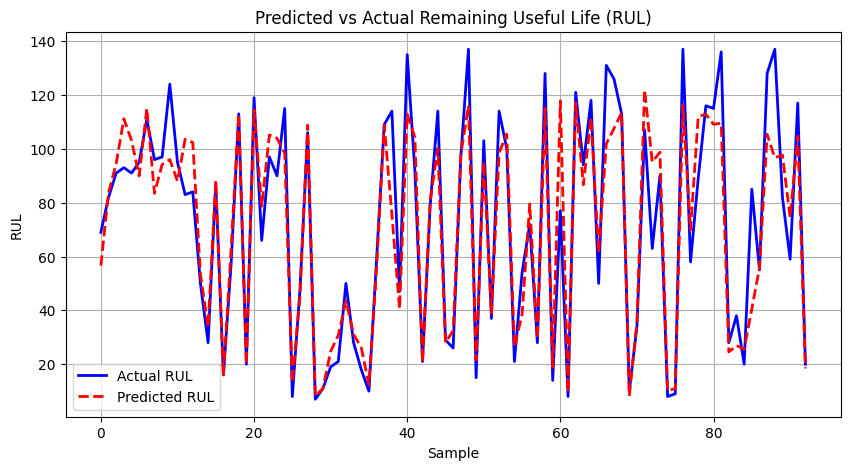

In [38]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual RUL', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted RUL', color='red', linestyle='--', linewidth=2)
plt.title('Predicted vs Actual Remaining Useful Life (RUL)')
plt.xlabel('Sample')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
engine_id = 50
engine_data = test[test['engine'] == engine_id]
X_engine, y_engine = create_sequences(engine_data, sequence_length, useful_sensors)
y_pred_engine = model.predict(X_engine)
smooth_window = 10
smooth_pred = np.convolve(y_pred_engine.flatten(), np.ones(smooth_window)/smooth_window, mode='valid')


plt.figure(figsize=(8, 5))
plt.plot(y_engine[:len(smooth_pred)], label='Actual RUL', color='blue')
plt.plot(smooth_pred, label='Smoothed Predicted RUL', color='red', linestyle='--')
plt.title(f'Engine {engine_id} - RUL over cycles')
plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'sequence_length' is not defined

In [ ]:
X_train.shape, model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 375,749 (1.43 MB)

 Trainable params: 125,249 (489.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 250,500 (978.52 KB)

((15631, 50, 15), None)